In [1]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARIMA

In [3]:
import requests
import io

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))

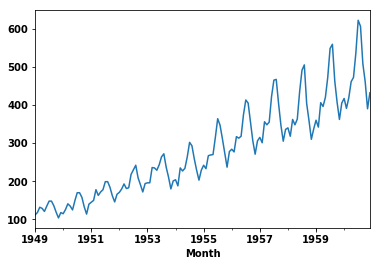

In [4]:
df_content = content.copy()
df_content['Month'] = pd.to_datetime(df_content['Month'], 
                                     infer_datetime_format=True)
y = pd.Series(df_content["#Passengers"].values, index=df_content['Month'])
y = y.astype('f')
y.plot()

In [5]:
# yは上のコードで取得した月ごとの旅客機の乗客数データ
y120 = y[:120]

C:\Users\sh70k\Anaconda3\envs\tsbook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sh70k\Anaconda3\envs\tsbook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\sh70k\Anaconda3\envs\tsbook\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<BarContainer object of 119 artists>

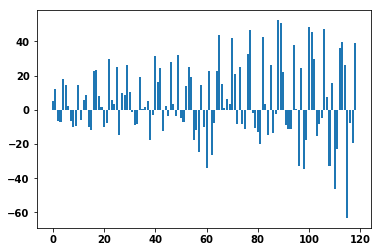

In [7]:
# 階差をとらないモデル(p=3,d=0,q=2)
model_d0 = ARIMA(y120, (3, 0, 2))
results_d0 = model_d0.fit()
res_d0 = results_d0.resid
# 残差の出力
plt.bar(range(len(res_d0[1:])), res_d0[1:])

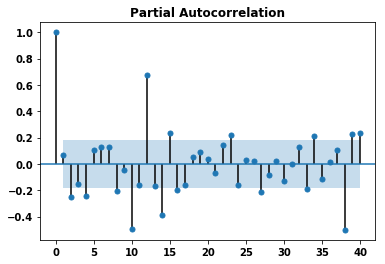

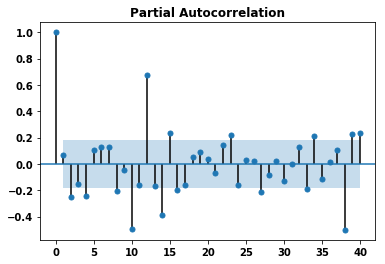

In [14]:
# 偏自己相関
tsaplots.plot_pacf(res_d0[1:], lags=40)
# ランダムウォーク過程のため自己相関はないことが確認できた

C:\Users\sh70k\Anaconda3\envs\tsbook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


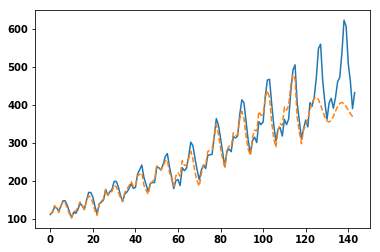

In [9]:
# 将来予測
# トレンドが捉えられていない
# 循環変動も捉えられていない

# 原系列の表示
plt.plot(y.values, label='observation')
# インサンプル（学習に使ったサンプルデータ）と
# ARIMA(3, 0, 2)による予測値を含めた系列の表示
# ARモデルの時とpredictの挙動が異なるので要注意
plt.plot(results_d0.predict(1, len(y)).values, 
         '--', label='forecast')

C:\Users\sh70k\Anaconda3\envs\tsbook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\sh70k\Anaconda3\envs\tsbook\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<BarContainer object of 119 artists>

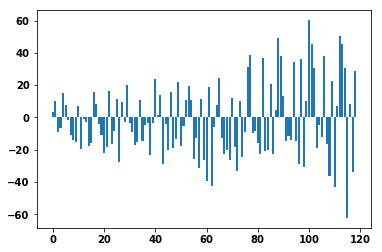

In [10]:
# 階差1をとったモデル(p=4,d=1,q=1)
model_d1 = ARIMA(y120, (4, 1, 1))
results_d1 = model_d1.fit()
res_d1 = results_d1.resid
# 残差の出力
plt.bar(range(len(res_d1)), res_d1)

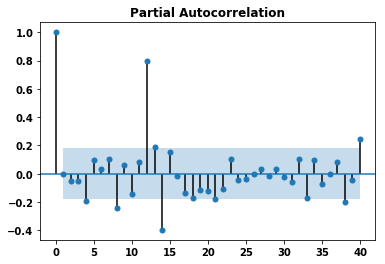

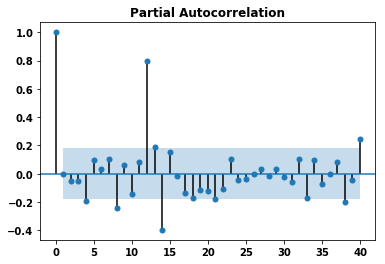

In [13]:
# 偏自己相関
tsaplots.plot_pacf(res_d1, lags=40)
# ランダムウォーク過程のため自己相関はないことが確認できた

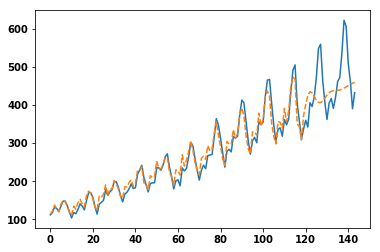

In [12]:
# 将来予測
# トレンドは捉えらている

# 原系列の表示
plt.plot(y.values, label='observation')
# インサンプル（学習に使ったサンプルデータ）と
# ARIMA(4, 1, 1)による予測値を含めた系列の表示
# 階差をとっているためインサンプルを
# 元データの形に戻すためtypオプションに'levels'を指定している
plt.plot(results_d1.predict(1, len(y), typ='levels').values, 
         '--', label='forecast')

# ARIMAでも上手くいく場合

In [15]:
def create_data(data_length, ar1 = 1, set_std=1, y0 = 0, random_seed=555):
    np.random.seed(random_seed)
    cur_y = y0
    val_list = []
    y_t2 = 0
    e_m1 = np.random.normal(loc=0, scale=set_std)
    
    for i in range(data_length):
        val_list.append(cur_y)
        if i > 0:
            y_t2 = val_list[-2]
        e_0 = np.random.normal(loc=0, scale=set_std)
        cur_y = 0.5 + cur_y + ar1 * (cur_y - y_t2) - 2*e_m1
        e_m1 = e_0
        
    return val_list

In [16]:
# データの作成
data_num = 1000
ar1 = 0.3
set_std = 5

base_data = create_data(data_num, ar1=ar1, set_std=set_std)

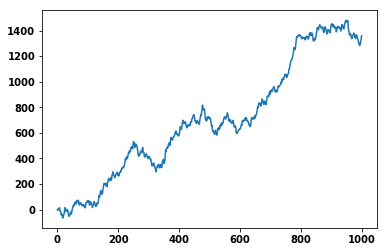

In [17]:
plt.plot(base_data)

<BarContainer object of 699 artists>

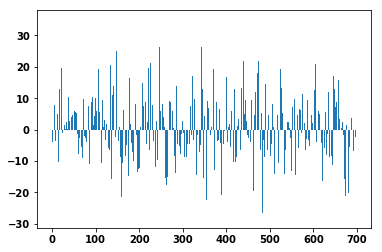

In [20]:
model_extra = ARIMA(base_data[:int(len(base_data)*0.7)], (1, 1, 2))
results_extra = model_extra.fit()
res_extra = results_extra.resid
# 残差の出力
plt.bar(range(len(res_extra)), res_extra)

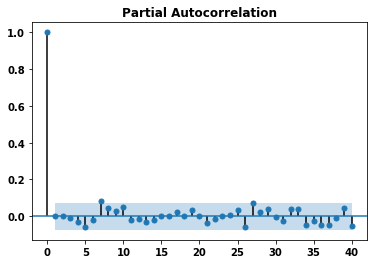

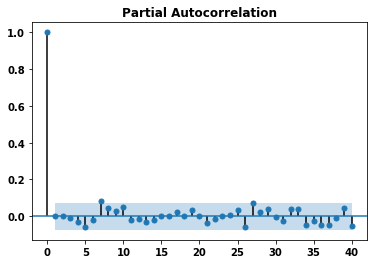

In [21]:
# 偏自己相関
tsaplots.plot_pacf(res_extra, lags=40)
# ランダムウォーク過程のため自己相関はないことが確認できた

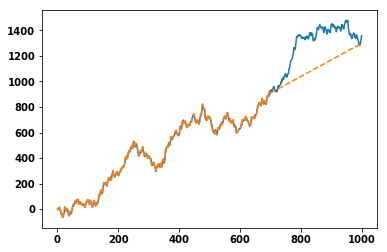

In [22]:
plt.plot(base_data, label='observation')
plt.plot(results_extra.predict(1,len(base_data), typ='levels'), 
         '--', label='forecast')

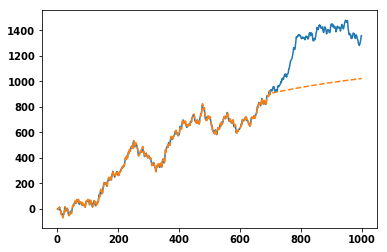

In [23]:
from statsmodels.tsa import ar_model

model = ar_model.AR(base_data[:int(len(base_data)*0.7)])
results = model.fit(maxlag=15)

plt.plot(base_data, label='observation')
# np.hstackはnp.concatenateでもよい
plt.plot(np.hstack([base_data[:15], 
                    results.fittedvalues, 
                    results.predict(int(len(base_data)*0.7), len(base_data), dynamic = True)]), 
         '--', label='forecast')